# Multiple Results Analysis

This notebook is intended to read a simulation results file with multiple simulations and results and create aggregate analyses and visualizations.

In [79]:
%matplotlib inline

import os
import sys 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tabulate import tabulate
from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

In [53]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [45]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures")
RESULTS  = os.path.join(FIXTURES, 'test-multi-results.json')

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        return json.load(f)

# Load the data
data = get_results_data()

# Get all the values for a particular key 
def results_values(*key):
    for result in data:
        value = result
        for k in key:
            value = value.get(k, {})
        yield value

rvals = results_values

In [47]:
# Print report details 
def report_settings():
    table = defaultdict(list)
    exclude = frozenset([
        'valid_locations', 'invalid_types', 
        'default_replica', 'default_consistency', 'default_latency', 
        'max_sim_time', 'title', 'description',
        'election_timeout', 'heartbeat_interval',
    ])
    
    for idx, conf in enumerate(rvals('settings')):
        eid = "e{:0>2}".format(idx)
        for key, val in conf.iteritems():
            if key in exclude: continue 
            if key == 'anti_entropy_delay': key = 'anti_entropy'
            if idx == 0:
                table[''].append(key)
            table[eid].append(val)
    
    for idx, conf in enumerate(rvals('topology', 'meta')):
        eid = "e{:0>2}".format(idx)
        for key, val in conf.iteritems():
            if key in exclude: continue 
            if idx == 0:
                table[''].append(key)
            table[eid].append(val)

    return tabulate(table, headers='keys')

print report_settings()

               e06          e07          e04          e05          e02         e03          e00      e01
-------------  -----------  -----------  -----------  -----------  ----------  -----------  -------  ---------
do_rumoring    True         True         True         True         True        True         True     True
access_mean    1800         1800         1800         1800         1800        1800         1800     1800
move_prob      0.2          0.2          0.2          0.2          0.2         0.2          0.2      0.2
anti_entropy   600          600          600          600          600         600          600      600
switch_prob    0.3          0.3          0.3          0.3          0.3         0.3          0.3      0.3
access_stddev  512          512          512          512          512         512          512      512
read_prob      0.68         0.68         0.68         0.68         0.68        0.68         0.68     0.68
random_seed    42           42           42   

In [62]:
def report_accesses(access='write'):
    table = defaultdict(list)
    
    for idx, results in enumerate(rvals('results')):
        counts = Counter()
        eid = "e{:0>2}".format(idx)
        
        for (rid, loc, ts) in results.get(access, []):
            counts[rid] += 1
            counts['total'] += 1
        
        for rid, count in sorted(counts.items(), key=itemgetter(0)):
            if idx == 0:
                table[''].append(rid)
            table[eid].append(count)
    
    print "{} Accesses:\n".format(access.capitalize())
    print tabulate(table, headers='keys')
    return table

table = report_accesses('read')

Read Accesses:

         e06    e07    e04    e05    e02    e03    e00    e01
-----  -----  -----  -----  -----  -----  -----  -----  -----
r0       217    213    247    177    205    187    216    247
r1       222    197    227    205    178    191    222    190
r2       182    208    196    217    199    181    177    177
r3       191    222    170    210    182    176    200    137
r4       193    198    179    160    180    252    186    189
r5       203    168    179    225    197    215    203    224
r6       213    191    212    197    250    194    204    181
r7       208    235    222    239    222    203    212    259
total   1629   1632   1632   1630   1613   1599   1620   1604


In [63]:
table = report_accesses('write')

Write Accesses:

         e06    e07    e04    e05    e02    e03    e00    e01
-----  -----  -----  -----  -----  -----  -----  -----  -----
r0        95    102    114     92    104    122    106    118
r1       102    103     97    101     87     94     99     91
r2        97    100     98     87    119     85    104     83
r3        91     84     77    114     84     71     83     71
r4       102     94     90     70     94    113     81     83
r5        92     81     87    102     93    107     89    102
r6        89     90    100     91    127     93     95     98
r7        89    105    108    114    104     97    109    124
total    757    759    771    771    812    782    766    770


In [77]:
def create_dataframe():
    table = []
    meta  = list(rvals('topology', 'meta'))

    for idx, results in enumerate(rvals('results')):
        data = {'eid': "e{:0>2}".format(idx)}
        data['variable'] = meta[idx]['variable']
        
        latency = meta[idx]['variable'].rstrip('ms').split('-')
        latency = sum(map(float, latency)) / 2
        
        data['mean latency'] = latency
        data['constant'] = meta[idx]['constant']
        data['users'] = 1
        for key, values in results.iteritems():
            if key == 'visibility latency':
                data[key] = sum(v[2] for v in values) / len(values)
            else:
                data[key] = len(values)
        table.append(data)
    
    return pd.DataFrame(table)

df = create_dataframe()
print df

  constant  eid  mean latency  read  stale reads  users     variable  \
0   N/A ms  e00         192.5  1620           38      1      5-380ms   
1   N/A ms  e01         567.5  1604          150      1    380-755ms   
2   N/A ms  e02         942.5  1613          302      1   755-1130ms   
3   N/A ms  e03        1317.5  1599          474      1  1130-1505ms   
4   N/A ms  e04        1692.5  1632          631      1  1505-1880ms   
5   N/A ms  e05        2067.5  1630          767      1  1880-2255ms   
6   N/A ms  e06        2442.5  1629          893      1  2255-2630ms   
7   N/A ms  e07        2817.5  1632          993      1  2630-3005ms   

   visibility latency  write  
0      2146585.984747    766  
1      2226637.918003    770  
2      2233210.501001    812  
3      2143206.784273    782  
4      2182725.530266    771  
5      2139018.409623    771  
6      2153897.643019    757  
7      2176353.758693    759  


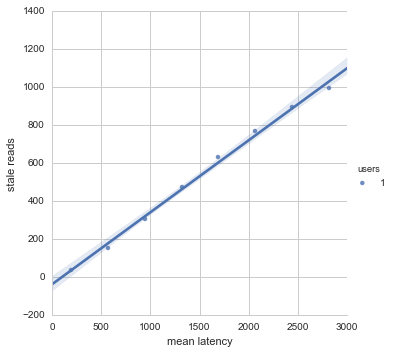

In [84]:
ax = sns.lmplot(x="mean latency", y="stale reads", hue='users', data=df)

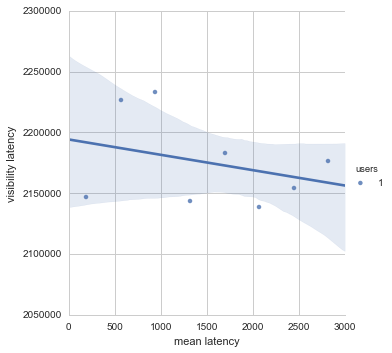

In [85]:
ax = sns.lmplot(x="mean latency", y="visibility latency", hue='users', data=df)